In [2]:
!pip install emoji

In [3]:
!pip install pyarabic

In [4]:
import sqlite3
import matplotlib.pyplot as plt
import re
import pandas as pd
import nltk
import unicodedata
from nltk.corpus import stopwords
import urllib.parse 
import emoji
import string
import seaborn as sns
from pyarabic.araby import strip_tashkeel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#from google.colab import files
#uploaded = files.upload()

In [7]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('/kaggle/input/corpus/dialects_database.db')
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print("We have the following tables in our database: \n", tables)

# Concatenate every table into a dataframe
dfs = {}
for table in tables['name']:
    query = "SELECT * FROM " + table + ";"
    dfs[table] = pd.read_sql(query, conn)
# Close the connection
conn.close()

We have the following tables in our database: 
          name
0     id_text
1  id_dialect


In [8]:
dfs['id_dialect'].head()

,id,dialect
0,1009754958479151232,LY
1,1009794751548313600,LY
2,1019989115490787200,LY
3,1035479791758135168,LY
4,1035481122921164800,LY


In [9]:
dfs['id_text'].head()

,id,text
0,1009754958479151232,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...
1,1009794751548313600,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...
2,1019989115490787200,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...
3,1035479791758135168,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...
4,1035481122921164800,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...


In [10]:
df = pd.merge(dfs['id_text'],dfs['id_dialect'], on='id')

In [11]:
df.head()

,id,text,dialect
0,1009754958479151232,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,1009794751548313600,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,1019989115490787200,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,1035479791758135168,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,1035481122921164800,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147725 entries, 0 to 147724
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       147725 non-null  int64 
 1   text     147725 non-null  object
 2   dialect  147725 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.5+ MB


In [13]:
df['dialect'].value_counts()

EG    57636
LY    36499
LB    27617
SD    14434
MA    11539
Name: dialect, dtype: int64

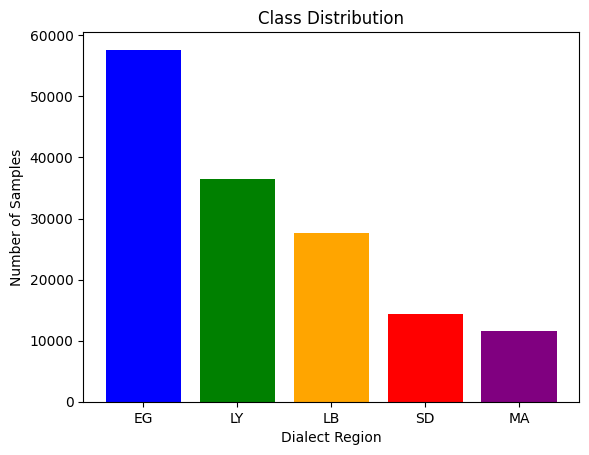

In [14]:
import matplotlib.pyplot as plt
class_counts = df['dialect'].value_counts()
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.bar(class_counts.index, class_counts.values,color=colors)
plt.xlabel('Dialect Region')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')

plt.show()

<AxesSubplot: xlabel='text', ylabel='dialect'>

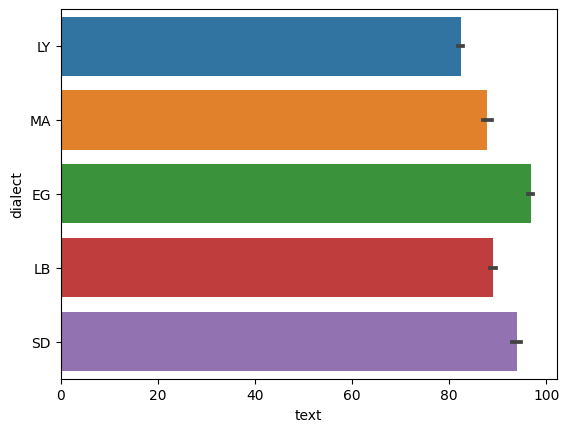

In [15]:
import seaborn as sns
sns.barplot(x=df["text"].str.len(),y=df["dialect"])

/tmp/ipykernel_31/1033474276.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["text"].str.len())


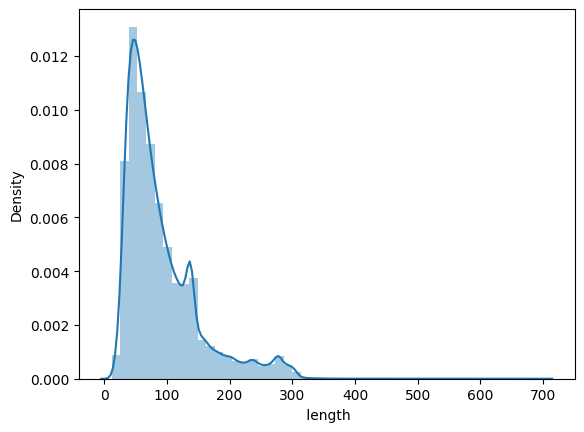

In [16]:
sns.distplot(df["text"].str.len())
plt.xlabel(' length');

In [17]:
df.duplicated("text").sum()

0

In [18]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('arabic'))
    words = text.split()
    text = [word for word in words if word.lower() not in stop_words]
    return ' '.join(text)

def remove_usernames(text):
    text = re.sub(r'@\w+', ' ', text)
    return text

def remove_emojis(text):
    cleaned_text = ""
    for char in text:
        if char not in emoji.emojize("").replace(":",""):
            cleaned_text += char
    return cleaned_text

def remove_numbers(text):
    text = re.sub(r'\d+', '  ', text)
    return text


def remove_links(text):
    
    words = text.split()
    filtered_words = []
    for word in words:
        url_parts = urllib.parse.urlparse(word)
        if not url_parts.scheme or url_parts.scheme.startswith('http'):
            filtered_words.append(word)
    return ' '.join(filtered_words)

def remove_english(text):
    english_pattern = re.compile(r'[a-zA-Z]+')
    cleaned_text = re.sub(english_pattern, ' ', text)
    return cleaned_text


def normalize_chars(text):
    text = re.sub("[إأآ]", "ا", text)
    
    return text

def remove_special_chars(text):
    
    special_chars_pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\d# ]+')
    text = re.sub(special_chars_pattern, ' ', text)
    return text

def remove_repeated_chars(text):
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    return text


def remove_punctuation(text):
    
    punctuation = string.punctuation + "ـ"
    cleaned_words = [word for word in text.split() if word.strip(punctuation)]
    text = ' '.join(cleaned_words)
    return text





In [19]:
def preprocess_text(text):
    text = remove_stopwords(text)
    text = remove_usernames(text)
    text = remove_emojis(text)
    text = remove_numbers(text)
    text = remove_links(text)
    text = remove_english(text)
    text = strip_tashkeel(text)
    text = normalize_chars(text)
    text= remove_repeated_chars(text)
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    return text

In [20]:
df['text']=df['text'].apply(preprocess_text)

In [21]:
df.head()

,id,text,dialect
0,1009754958479151232,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تق...,LY
1,1009794751548313600,الليبيين متقلبين بالنسبة ليا انا ميليشياوي زما...,LY
2,1019989115490787200,تانيه شاب ليبي بيرتاح لبنت مختلفة ويلاحظ انها ...,LY
3,1035479791758135168,رانيا عقليتك متخلفة اولا الانسان يلي يحتاج اهل...,LY
4,1035481122921164800,شكلك متعقدة علشان الراجل تحبيه ازوج بنت يتيمة ...,LY


In [39]:
le = LabelEncoder()
df['dialect'] = le.fit_transform(df['dialect'])


In [41]:
labels = le.classes_

In [44]:

# Retrieve the label for encoded value 0
label_0 = le.inverse_transform([0])[0]

# Retrieve the label for encoded value 1
label_1 = le.inverse_transform([1])[0]
label_2 = le.inverse_transform([2])[0]
label_3 = le.inverse_transform([3])[0]
label_4 = le.inverse_transform([4])[0]

# Print the labels
print("Label for encoded value 0:", label_0)
print("Label for encoded value 1:", label_1)
print("Label for encoded value 1:", label_2)
print("Label for encoded value 1:", label_3)
print("Label for encoded value 1:", label_4)

Label for encoded value 0: 0
Label for encoded value 1: 1


In [25]:
labels

array(['EG', 'LB', 'LY', 'MA', 'SD'], dtype=object)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147725 entries, 0 to 147724
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       147725 non-null  int64 
 1   text     147725 non-null  object
 2   dialect  147725 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [27]:
df=df = df.drop('id', axis=1)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147725 entries, 0 to 147724
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     147725 non-null  object
 1   dialect  147725 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [29]:
nltk.download('punkt')


# Tokenize a text string into words
#Tokenize the text column of the DataFrame
#df['text'] = df['text'].apply(nltk.word_tokenize)

#Print the tokenized data
#print(df['text'])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
# Tokenize data
'''tokenized_data = []
for text in df['text']:
    tokens = [word for word in nltk.word_tokenize(text) if word.isalpha()]
    tokenized_data.append(' '.join(tokens))'''

"tokenized_data = []\nfor text in df['text']:\n    tokens = [word for word in nltk.word_tokenize(text) if word.isalpha()]\n    tokenized_data.append(' '.join(tokens))"

In [31]:
#X_train, X_test, y_train, y_test = train_test_split(tokenized_data, df['dialect'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['dialect'], test_size=0.2, random_state=42, shuffle=True)


In [32]:
!pip install pad_sequences

  Preparing metadata (setup.py) ... done
  Created wheel for pad_sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10216 sha256=b2e3ee6dffee8af064914a0ec0a1610fc20b33478f59a161b9a1182943f8d700
  Stored in directory: /root/.cache/pip/wheels/48/9d/22/0a6305b87a9cc46ccc032060a041c3b59f39ac462f7358997e
Successfully built pad_sequences


In [33]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
# Tokenize the text data
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [37]:
import pickle

pickle.dump(tokenizer, open("tokenizer.pkl", "wb")) # wb: write binary

In [ ]:
import pickle

pickle.dump(tokenizer, open("../models/tokenizer.pkl", "wb")) # wb: write binary

In [33]:
# Convert the text data into TF-IDF vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
train_vectors = vectorizer.transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [34]:
max_len = 100
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_len)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [36]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the embedding layer and other model layers
embedding_layer = Embedding(len(tokenizer.word_index)+1, output_dim=64, input_length=max_len)
lstm_layer = LSTM(units=128)
dense_layer1 = Dense(units=64, activation='relu',kernel_regularizer=regularizers.l2(0.01))
dense_layer2 = Dense(units=32, activation='relu',kernel_regularizer=regularizers.l2(0.01))
dense_layer3 = Dense(units=5, activation='softmax')
'''embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_len)
lstm_layer = LSTM(units=64)
dense_layer = Dense(units=5, activation='softmax')'''
# Define the learning rate schedule
initial_learning_rate = 0.001

def learning_rate_scheduler(epoch):
    return initial_learning_rate * math.exp(-0.1 * epoch)
# Define the RNN model
model = Sequential()
model.add(embedding_layer)
model.add(lstm_layer)
model.add(dense_layer1)
model.add(Dropout(0.2))
model.add(BatchNormalization())
#model.add(dense_layer2)
model.add(dense_layer3)

In [38]:
import tensorflow as tf

In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

# Train the model
history = model.fit(train_padded_sequences, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])
#model.fit(train_padded_sequences, y_train, validation_data=(test_padded_sequences, y_test), epochs=10, batch_size=32)

Epoch 1/20
739/739 [==============================] - 67s 83ms/step - loss: 0.7961 - accuracy: 0.7498 - val_loss: 0.5524 - val_accuracy: 0.8105
Epoch 2/20
739/739 [==============================] - 18s 25ms/step - loss: 0.2519 - accuracy: 0.9218 - val_loss: 0.6021 - val_accuracy: 0.8086
Epoch 3/20
739/739 [==============================] - 16s 22ms/step - loss: 0.1213 - accuracy: 0.9656 - val_loss: 0.7311 - val_accuracy: 0.7988
Epoch 4/20
739/739 [==============================] - 15s 21ms/step - loss: 0.0794 - accuracy: 0.9776 - val_loss: 0.8273 - val_accuracy: 0.7919


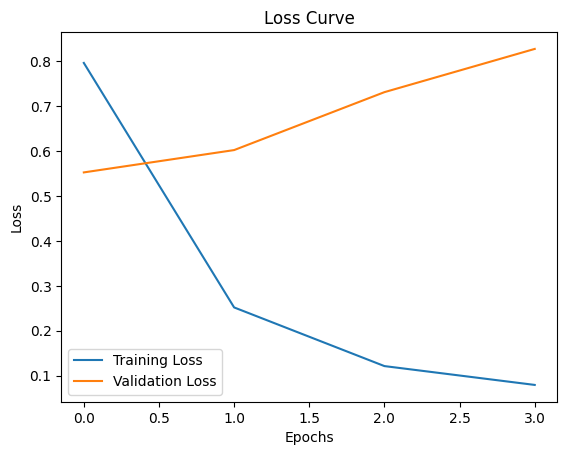

In [40]:
# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# Evaluate the model
#test_loss, test_acc = model.evaluate(test_padded_sequences, y_test, verbose=2)
#print('Test accuracy:', test_acc)

In [42]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_padded_sequences, y_test, verbose=0)

# Print the test loss, accuracy, and F1-score
print("Test loss: {:.4f}".format(loss))
print("Test accuracy: {:.4f}".format(accuracy))



Test loss: 0.5470
Test accuracy: 0.8115


In [43]:
import numpy as np

In [44]:
# Make predictions on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
y_pred = model.predict(test_padded_sequences)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
#y_true_labels = np.argmax(y_test_encoded, axis=1)  # Replace y_true with your true labels

# Generate classification report
report = classification_report(y_test, y_pred_labels)

# Print the classification report
print(report)


924/924 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     11484
           1       0.72      0.90      0.80      5578
           2       0.82      0.77      0.80      7268
           3       0.85      0.65      0.73      2283
           4       0.75      0.61      0.67      2932

    accuracy                           0.81     29545
   macro avg       0.80      0.76      0.78     29545
weighted avg       0.82      0.81      0.81     29545



In [45]:
y_pred_labels

array([3, 0, 2, ..., 0, 1, 1])

In [46]:
from tensorflow.keras.models import load_model

# Load the saved model
model.save('my_model.h5')

In [47]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(r'/kaggle/working/my_model.h5')

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the embedding layer and other model layers
embedding_layer = Embedding(len(tokenizer.word_index)+1, output_dim=64, input_length=max_len)
lstm_layer = LSTM(units=128)
dense_layer1 = Dense(units=64, activation='relu',kernel_regularizer=regularizers.l2(0.1))
dense_layer2 = Dense(units=32, activation='relu',kernel_regularizer=regularizers.l2(0.1))
dense_layer3 = Dense(units=5, activation='softmax')
'''embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_len)
lstm_layer = LSTM(units=64)
dense_layer = Dense(units=5, activation='softmax')'''
# Define the learning rate schedule
initial_learning_rate = 0.001

def learning_rate_scheduler(epoch):
    return initial_learning_rate * math.exp(-0.1 * epoch)
# Define the RNN model
model = Sequential()
model.add(embedding_layer)
model.add(lstm_layer)
model.add(dense_layer1)
model.add(Dropout(0.2))
model.add(BatchNormalization())
#model.add(dense_layer2)
model.add(dense_layer3)

In [85]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

# Train the model2
history = model.fit(train_padded_sequences, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])
#model.fit(train_padded_sequences, y_train, validation_data=(test_padded_sequences, y_test), epochs=10, batch_size=32)

Epoch 1/20
739/739 [==============================] - 44s 55ms/step - loss: 1.3387 - accuracy: 0.7437 - val_loss: 0.5949 - val_accuracy: 0.7913
Epoch 2/20
739/739 [==============================] - 16s 22ms/step - loss: 0.2781 - accuracy: 0.9171 - val_loss: 0.6171 - val_accuracy: 0.8061
Epoch 3/20
739/739 [==============================] - 14s 19ms/step - loss: 0.1405 - accuracy: 0.9628 - val_loss: 0.7239 - val_accuracy: 0.8016
Epoch 4/20
739/739 [==============================] - 12s 16ms/step - loss: 0.0905 - accuracy: 0.9767 - val_loss: 0.8218 - val_accuracy: 0.7985


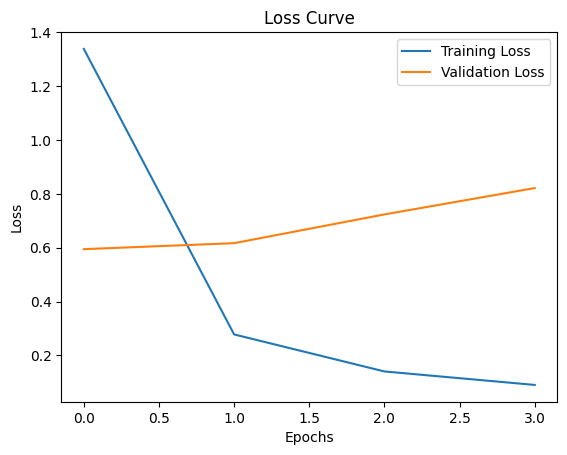

In [86]:
# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_padded_sequences, y_test, verbose=0)

# Print the test loss, accuracy, and F1-score
print("Test loss: {:.4f}".format(loss))
print("Test accuracy: {:.4f}".format(accuracy))



Test loss: 0.5920
Test accuracy: 0.7946


In [88]:
# Make predictions on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
y_pred = model.predict(test_padded_sequences)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
#y_true_labels = np.argmax(y_test_encoded, axis=1)  # Replace y_true with your true labels

# Generate classification report
report = classification_report(y_test, y_pred_labels)

# Print the classification report
print(report)


924/924 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     11484
           1       0.95      0.69      0.80      5578
           2       0.64      0.91      0.75      7268
           3       0.91      0.60      0.72      2283
           4       0.80      0.55      0.65      2932

    accuracy                           0.79     29545
   macro avg       0.83      0.72      0.76     29545
weighted avg       0.82      0.79      0.79     29545

